# Synthetic Control

ECON526

Paul Schrimpf (University of British Columbia)

# Introduction

$$
\def\Er{{\mathrm{E}}}
\def\En{{\mathbb{E}_n}}
\def\cov{{\mathrm{Cov}}}
\def\var{{\mathrm{Var}}}
\def\R{{\mathbb{R}}}
\newcommand\norm[1]{\left\lVert#1\right\rVert}
\def\rank{{\mathrm{rank}}}
\newcommand{\inpr}{ \overset{p^*_{\scriptscriptstyle n}}{\longrightarrow}}
\def\inprob{{\,{\buildrel p \over \rightarrow}\,}}
\def\indist{\,{\buildrel d \over \rightarrow}\,}
\DeclareMathOperator*{\plim}{plim}
$$

## Setup

-   1 treated unit, observed $T_0$ periods before treatment, $T_1$
    periods after
-   $J$ untreated units
-   $J$, $T_0$ moderate in size
-   Formalisation of comparative case study

## Example: California Tobacco Control Program

-   Code and copy of data from Facure (2022)
-   Data used in Abadie, Diamond, and Hainmueller (2010)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

#if 'ipykernel' in sys.modules:
#    %matplotlib inline

pd.set_option("display.max_columns", 20)
style.use("fivethirtyeight")

## Data: California Tobacco Control Program

In [2]:
cigar = pd.read_csv("data/smoking.csv")
cigar.query("california").head()

## Cigarette Sales Trends

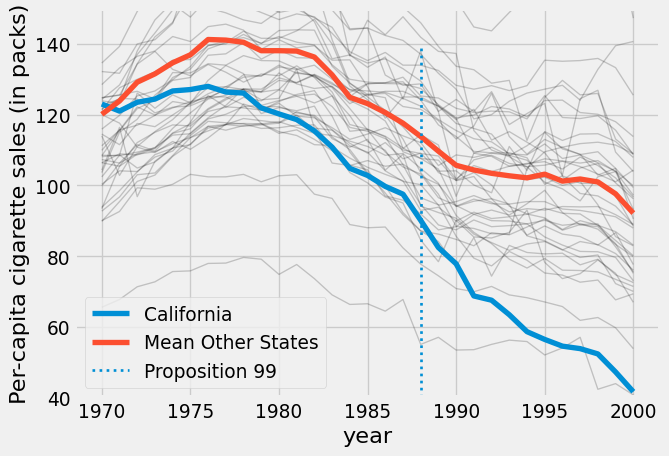

In [3]:
ax = plt.subplot(1, 1, 1)
for gdf in cigar.groupby("state"):
    ax.plot(gdf[1]['year'],gdf[1]['cigsale'], alpha=0.2, lw=1, color="k")

ax.set_ylim(40, 150)
ax.plot(cigar.query("california")['year'], cigar.query("california")['cigsale'], label="California")
cigar.query("not california").groupby("year")['cigsale'].mean().plot(ax=ax, label="Mean Other States")

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend()
plt.show()

## Which Comparison?

-   All states?
-   States bordering California?
-   States with similar characteristics? Which characteristics?

## Synthetic Control

-   Compare treated unit (California) to weighted average of untreated
    units
-   Weights chosen to make sythetic control close to California

## Synthetic Control

-   Potential outcomes $Y_{it}(0), Y_{it}(1)$
-   For $t>T_0$, estimate treatment effect on treated unit as $$
    \hat{\tau}_{1t} = Y_{1t} -
    \underbrace{\sum_{j=2}^{J+1} \hat{w}_j Y_{jt}}_{\hat{Y}_{1t}(0)}
    $$
-   $\hat{w}_j$ chosen to make synthetic control close to treated unit
    in before treatment

## Variables to Match

-   Vector of pretreatment variables for treated unit $$
    \mathbf{X}_1 = \left(Y_{11}, \cdots Y_{1T_0}, z_{11}, \cdots, z_1K \right)^T
    $$
-   Matrix of same variabels for untreated $$
    \mathbf{X}_0 = \begin{pmatrix}
    Y_{21} & \cdots & Y_{2T_0} & z_{21} & \cdots & z_{2K} \\
    \vdots &        &          &        &        & \vdots \\
    Y_{J+1,1} & \cdots & Y_{J+1,T_0} & z_{J+1,1} & \cdots & z_{J+1,K}
    \end{pmatrix}^T
    $$

## Weights

-   Weights minimize difference $$
    \begin{align*}
    \hat{W} = & \textrm{arg}\min_{W \in \R^J} \Vert \mathbf{X}_1 - \mathbf{X}_0 W \Vert_V \\
    & s.t. \sum_{j=2}^{J+1} w_j = 1 \\
    & \;\;\; 0 \leq w_j \leq 1 \;\; \forall j
    \end{align*}
    $$

-   $\Vert x \Vert_V = x' V x$ is a weighted norm. Choose $V$ to
    e.g. weight by inverse variance

## Computing Weights

In [4]:
features = ["cigsale", "retprice"]
inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state
inverted.head()

5 rows × 39 columns

## Computing Weights

In [5]:
from scipy.optimize import fmin_slsqp
from toolz import reduce, partial

X1 = inverted[3].values # state of california
X0 = inverted.drop(columns=3).values  # other states

def loss_w(W, X0, X1) -> float:
    return np.sqrt(np.mean((X1 - X0.dot(W))**2))


def get_w(X0, X1):
    w_start = [1/X0.shape[1]]*X0.shape[1]
    weights = fmin_slsqp(partial(loss_w, X0=X0, X1=X1),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

## Examining Weights

-   Weights tend to be sparse
-   Good idea to examine which untreated units get positive weight
-   Should look at state names, but the data does not have them, and the
    `state` variable is not FIPs code or any standard identifier

In [6]:
calif_weights = get_w(X0, X1)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000424

array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

## Effect of California Tobacco Control Program

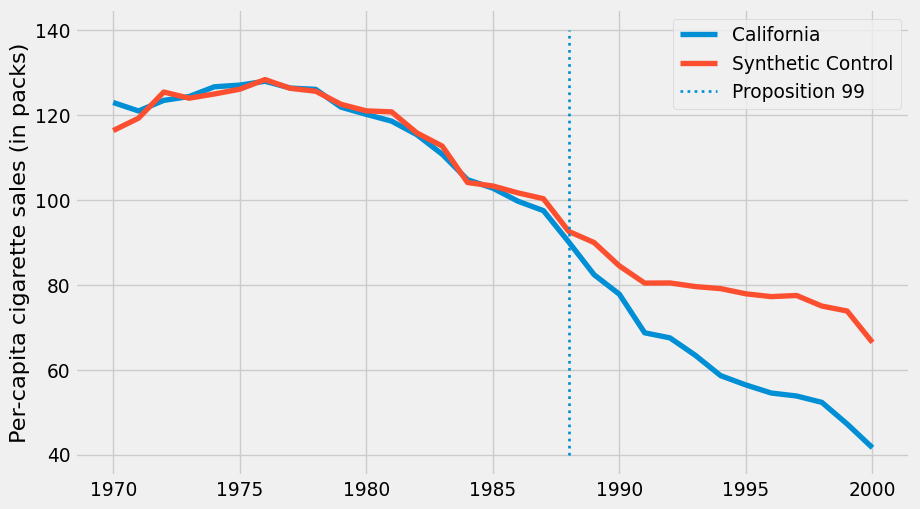

In [7]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend()
plt.show()

## When Does this Work?

-   If data generated by linear factor model: $$
    Y_{jt}(0) = \delta_t + \theta_t Z_j + \lambda_t \mu_j + \epsilon_{jt}
    $$
    -   Observed $Z_j$
    -   Unobserved$\lambda_t$, $\mu_j$
-   As $T_0$ increases or variance of $\epsilon_{jt}$ decreases, bias of
    $\hat{\tau}_{it}$ decreases
    -   Needs $\mathbf{X}_1 \approx \mathbf{X}_0 W$

## Choices

-   Variables in $\mathbf{X}$ to match
    -   Fewer make eaiser to have $\mathbf{X}_1 \approx \mathbf{X}_0 W$
    -   But fewer make $W$ depend more on $\epsilon$
-   Set of untreated units to consider
    -   More units makes eaiser to have
        $\mathbf{X}_1 \approx \mathbf{X}_0 W$
    -   But risk of overfitting

# Inference

## Inference

-   Estimator $$
    \hat{\tau}_{1t} = Y_{1t} -
    \underbrace{\sum_{j=2}^{J+1} \hat{w}_j Y_{jt}}_{\hat{Y}_{1t}(0)}
    $$
    -   single observation of $Y_{1t}$
    -   $\hat{w}_j$ depends on pre-treatment variables
        $\underbrace{\mathbf{X}_1, \mathbf{X}_0}_{(J+1) \times (T_0 + K)}$
    -   $J$ values of $Y_{jt}$
-   Usual asymptotics not applicable

## Treatment Permutation

-   Compute estimate pretending each of the $J$ untreated units were
    treated instead
-   Use as distribution of $\hat{\tau}_{1t}$ under $H_0: \tau_{1t} = 0$

## Treatment Permutation

In [8]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    features = ["cigsale", "retprice"]
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    X1 = inverted[state].values # treated
    X0 = inverted.drop(columns=state).values # donor pool

    weights = get_w(X0, X1)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))
    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

from joblib import Parallel, delayed

control_pool = cigar["state"].unique()
parallel_fn = delayed(partial(synthetic_control, data=cigar))
synthetic_states = Parallel(n_jobs=20)(parallel_fn(state) for state in control_pool);

## Treatment Permutation

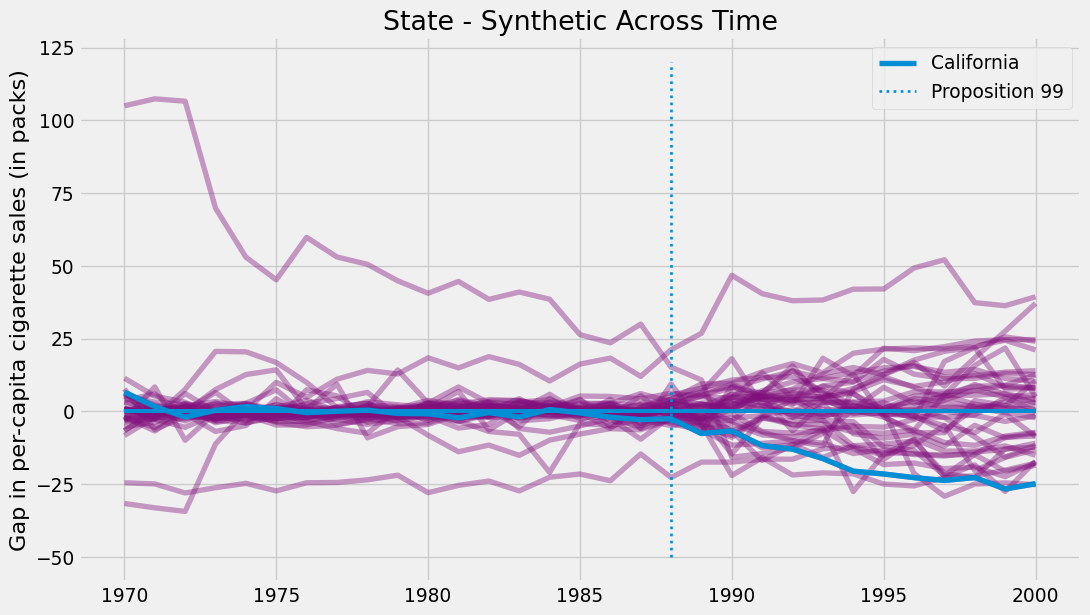

In [9]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend()
plt.show()

## Treatment Permutation Inference

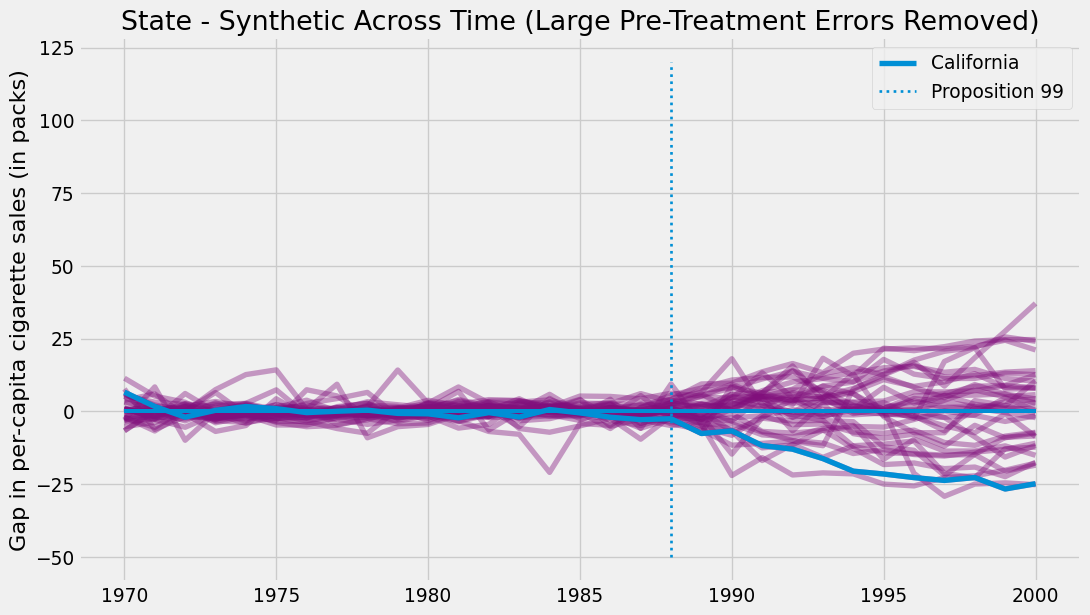

In [10]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"]
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:

    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend()
plt.show()

## Treatment Permutation Inference: Testing $H_0: \tau=0$

In [11]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1]

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

np.mean(np.array(effects) < calif_effect)

California Treatment Effect for the Year 2000: -24.83015975607075

0.02857142857142857

## Design Based Inference

-   Sampling based inference:
    -   Specify data generating process (DGP)
    -   Find distribution of estimator under repeated sampling of
        datasets from DGP

-   Design based inference:
    -   Condition on dataset you have
    -   Randomness of estimator from random assignment of treatment
    -   See Abadie et al. (2020) for more information

-   Treatment permutation inference is design based inference assuming
    the treated unit was chosen uniformly at random from all units

## Design Based / Treatment Permutation Inference

-   Pros:
    -   Easy to implement and explain
    -   Intuitive appeal, similar to placebo tests
    -   Minimal assumptions about DGP
-   Cons:
    -   Assumption about randomized treatment assignment is generally
        false
    -   Needs modification to test hypotheses other than $H_0: \tau=0$ &
        to construct confidence intervals

## Prediction Intervals

-   Estimation error is a prediction error $$
    \begin{align*}
    \hat{\tau}_{1t} = & Y_{1t} -
    \underbrace{\hat{Y}_{1t}(0)}_{\text{prediction given $Y_{jt}, \mathbf{X}_0$}}
    \\
    = &  \underbrace{Y_{1t}(1) - \color{grey}{Y_{1t}(0)}}_{\tau_{1t}} + \underbrace{\color{grey}{Y_{1t}(0)} - \hat{Y}_{1t}(0)}_{\text{prediction error}}
    \end{align*}
    $$

-   Many statistical methods for calculating distribution of prediction
    error
-   Difficulties:
    -   High-dimensional: number of weights comparable to number of
        observations and dimension of predictors
    -   Moderate sample sizes

## Prediction Intervals

-   Modern approaches accomodate high-dimensionality and give
    non-asymptotic results
-   Chernozhukov, Wüthrich, and Zhu (2021) : construct prediction
    intervals by permuting residuals (conformal inference)
-   Cattaneo, Feng, and Titiunik (2021) : divide prediction error into
    two pieces: estimation of $\hat{w}$ and unpredictable randomness in
    $Y_{1t}(0)$

## Catteneo, Feng, & Titiunik

-   Given coverage level $\alpha$, gives interval
    $\mathcal{I}_{1-\alpha}$ such that $$
    P\left[ P\left(\tau_{1t} \in \mathcal{I}_{1-\alpha} | \mathbf{X}_0, \{y_{jt}\}_{j=1}^J\right) > 1-\alpha-\epsilon(T_0) \right] > 1 - \pi(T_0)
    $$ where $\epsilon(T_0) \to 0$ and $\pi(T_0) \to 0$ as
    $T_0 \to \infty$

-   prediction error comes from

    1.  estimation of $\hat{w}$, options refer to `u_` in `scpi_pkg`
    2.  unobservable stochastic error in $Y_{1t}(0)$, options begin with
        `e_` in `scpi_pkg`

-   valid under broad range of DGPs, but appropriate interval does
    depend on dependence of data over time, stationarity, assumptions
    about distribution of error given predictors

## Software

-   [scpi_pkg](https://github.com/nppackages/scpi) recommended, created
    by leading econometricians
-   [pysyncon](https://github.com/sdfordham/pysyncon?tab=readme-ov-file)
    actively maintained, well-documented, but appears not popular
-   [SpareSC](https://github.com/microsoft/SparseSC) created by
    researchers at Microsoft, uses particular variant
-   [scinference](https://github.com/kwuthrich/scinference) R package
    accompanying Chernozhukov, Wüthrich, and Zhu (2021)

# scpi_pkg

## Data Preparation

In [12]:
import random
from scpi_pkg.scdata import scdata
from scpi_pkg.scest import scest
from scpi_pkg.scplot import scplot
scdf = scdata(df=cigar, id_var="state", time_var="year", outcome_var="cigsale",
              period_pre=cigar.query("not after_treatment").year.unique(),
              period_post=cigar.query("after_treatment").year.unique(),
              unit_tr=calif_number,
              unit_co=cigar.query("not california").state.unique(),
              features=["cigsale","retprice"],
              cov_adj=None, cointegrated_data=True,
              constant=False)

## Point Estimation

-----------------------------------------------------------------------
Call: scest
Synthetic Control Estimation - Setup

Constraint Type:                                                simplex
Constraint Size (Q):                                                  1
Treated Unit:                                                         3
Size of the donor pool:                                              38
Features                                                              2
Pre-treatment period                                          1970-1988
Pre-treatment periods used in estimation per feature:
 Feature  Observations
 cigsale            19
retprice            19
Covariates used for adjustment per feature:
 Feature  Num of Covariates
 cigsale                  0
retprice                  0

Synthetic Control Estimation - Results

Active donors: 5

Coefficients:
                    Weights
Treated Unit Donor         
3            1        0.000
             10       0.000
          

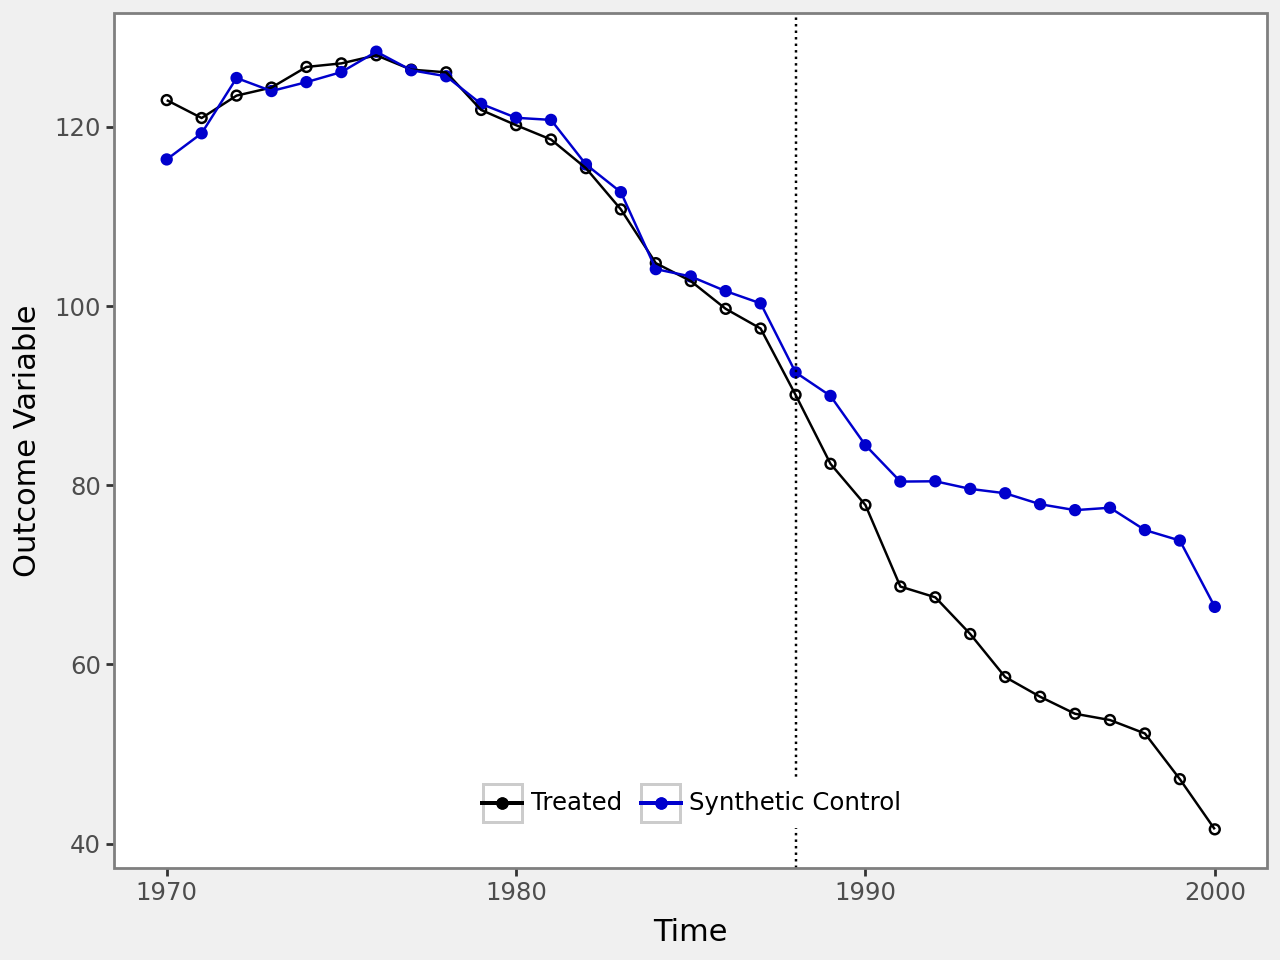

In [13]:
est_si = scest(scdf, w_constr={'name': "simplex"})
print(est_si)
est_si2 = scest(scdf, w_constr={'p': 'L1', 'dir': '==', 'Q': 1, 'lb': 0})
print(est_si2)
scplot(est_si)

## Inference

-----------------------------------------------
Estimating Weights...
Quantifying Uncertainty
Maximum expected execution time: 2 minutes.
 

20/200 iterations completed (10%)
40/200 iterations completed (20%)
60/200 iterations completed (30%)
80/200 iterations completed (40%)
100/200 iterations completed (50%)
120/200 iterations completed (60%)
140/200 iterations completed (70%)
160/200 iterations completed (80%)
180/200 iterations completed (90%)
200/200 iterations completed (100%)

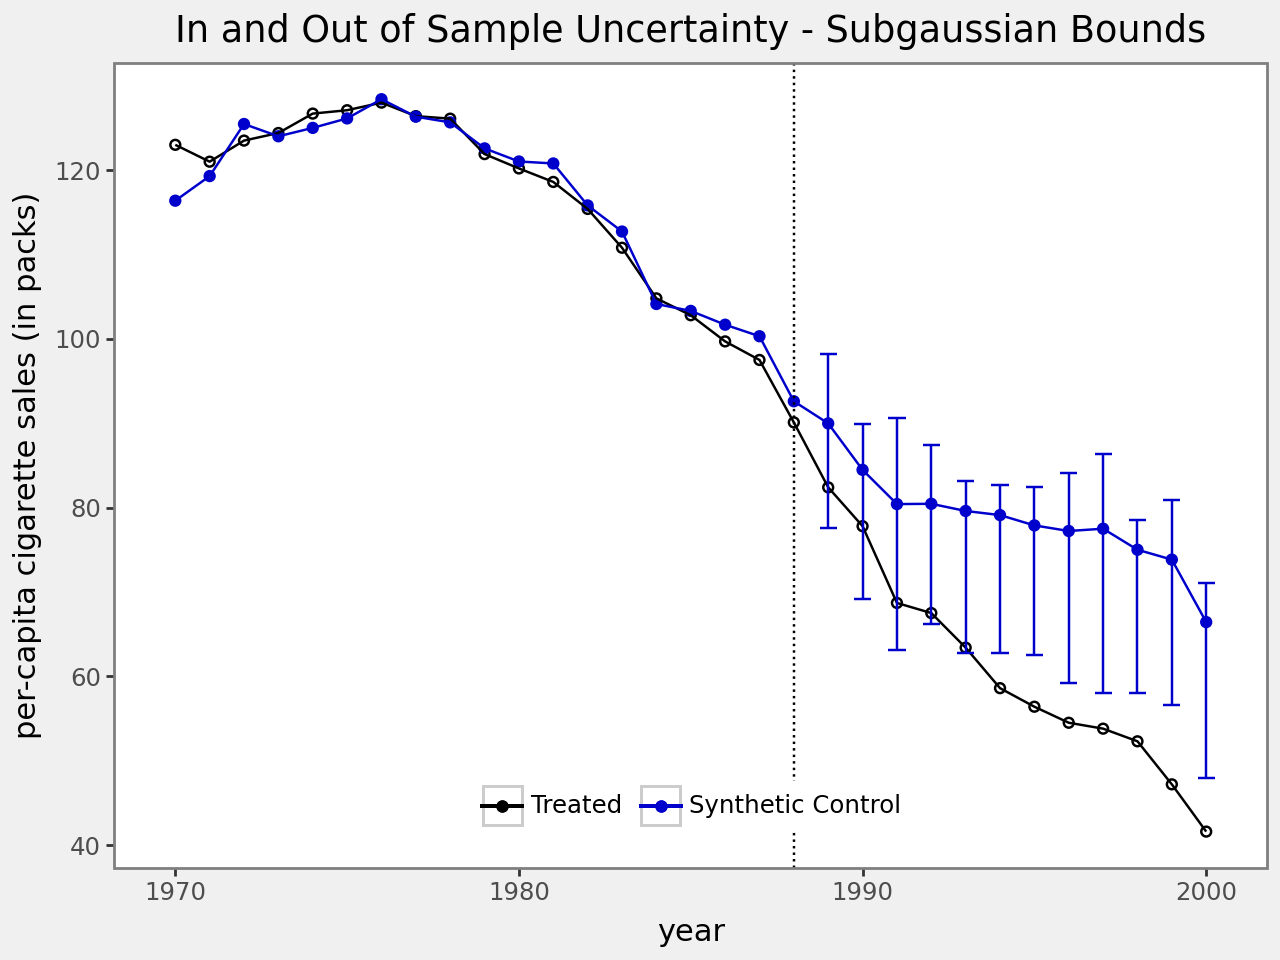

In [14]:
from scpi_pkg.scpi import scpi
import random
w_constr = {'name': 'simplex', 'Q': 1}
u_missp = True
u_sigma = "HC1"
u_order = 1
u_lags = 0
e_method = "gaussian"
e_order = 1
e_lags = 0
e_alpha = 0.05
u_alpha = 0.05
sims = 200
cores = 1

random.seed(8894)
result = scpi(scdf, sims=sims, w_constr=w_constr, u_order=u_order, u_lags=u_lags,
              e_order=e_order, e_lags=e_lags, e_method=e_method, u_missp=u_missp,
              u_sigma=u_sigma, cores=cores, e_alpha=e_alpha, u_alpha=u_alpha)
scplot(result, e_out=True, x_lab="year", y_lab="per-capita cigarette sales (in packs)")

## Sources and Further Reading

-   example code from Facure (2022) [chapter
    15](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html)
-   notation and theory follows Abadie (2021)
-   Huntington-Klein (2021) [chapter
    21.2](https://theeffectbook.net/ch-TheEdge.html#synthetic-control)
-   More technical:
    -   Cattaneo et al. (2022) user guide for `scpi_pkg`
    -   Abadie, Diamond, and Hainmueller (2010) important paper
        popularizing synthetic control and permutation inference
    -   Abadie and Cattaneo (2021) lists recent statistical advances in
        synthetic control

## References

Abadie, Alberto. 2021. “Using Synthetic Controls: Feasibility, Data
Requirements, and Methodological Aspects.” *Journal of Economic
Literature* 59 (2): 391–425. <https://doi.org/10.1257/jel.20191450>.

Abadie, Alberto, Susan Athey, Guido W. Imbens, and Jeffrey M.
Wooldridge. 2020. “Sampling-Based Versus Design-Based Uncertainty in
Regression Analysis.” *Econometrica* 88 (1): 265–96.
https://doi.org/<https://doi.org/10.3982/ECTA12675>.

Abadie, Alberto, and Matias D. Cattaneo. 2021. “Introduction to the
Special Section on Synthetic Control Methods.” *Journal of the American
Statistical Association* 116 (536): 1713–15.
<https://doi.org/10.1080/01621459.2021.2002600>.

Abadie, Alberto, Alexis Diamond, and Jens Hainmueller. 2010. “Synthetic
Control Methods for Comparative Case Studies: Estimating the Effect of
California’s Tobacco Control Program.” *Journal of the American
Statistical Association* 105 (490): 493–505.
<https://doi.org/10.1198/jasa.2009.ap08746>.

Cattaneo, Matias D., Yingjie Feng, Filippo Palomba, and Rocio Titiunik.
2022. “Scpi: Uncertainty Quantification for Synthetic Control Methods.”

Cattaneo, Matias D., Yingjie Feng, and Rocio Titiunik. 2021. “Prediction
Intervals for Synthetic Control Methods.” *Journal of the American
Statistical Association* 116 (536): 1865–80.
<https://doi.org/10.1080/01621459.2021.1979561>.

Chernozhukov, Victor, Kaspar Wüthrich, and Yinchu Zhu. 2021. “An Exact
and Robust Conformal Inference Method for Counterfactual and Synthetic
Controls.” *Journal of the American Statistical Association* 116 (536):
1849–64. <https://doi.org/10.1080/01621459.2021.1920957>.

Facure, Matheus. 2022. *Causal Inference for the Brave and True*.
<https://matheusfacure.github.io/python-causality-handbook/landing-page.html>.

Huntington-Klein, Nick. 2021. *The Effect: An Introduction to Research
Design and Causality*. CRC Press. <https://theeffectbook.net/>.